# Riemannian gradient ascent with Sinkhorn (RGAS)
In this tutorial we implement the Riemannian gradient ascent with Sinkhorn (RGAS) algorithm from {cite}`lin:20`.

The Wasserstein distance, derived from the optimal transport problem, is a useful metric for comparing probability measures due to its theoretical properties and practical implications. However, it has limitations in large-scale scenarios. As the dimension of the data space increases, computing the Wasserstein distance becomes computationally expensive due to its definition as a linear program. Additionally, its sample complexity can grow exponentially with the problem dimension. To overcome these issues, recent advancements in computational optimal transport methods have been developed. These methods offer alternatives to the Wasserstein distance with improved computational and statistical properties, enabling the application of optimal transport in machine learning.

One approach is to compute the Wasserstein distance between lower-dimensional representations of the distributions being compared. This involves projecting the d-dimensional distributions onto a k-dimensional subspace (where k < d) to maximize the Wasserstein distance between these reduced dimensions. This approach, known as the Projection Robust Wasserstein (PRW) distance or Wasserstein Projection Pursuit, has gained popularity. Previous research has shown that, under certain assumptions about the structure of the high-dimensional distributions (referred to as the "spiked transport model"), PRW provides a sample complexity that is independent of the dimension. However, efficiently computing PRW remains challenging due to the non-convex nature of the underlying max-min optimization problem.

The paper {cite}`lin:20` proposes a max-min optimization model for computing the PRW distance over the Stiefel manifold.

Define the Stiefel manifold $St(d, k) : = \{U \in \mathbb{R}^{d \times k} \mid U^\top U = I_k\}$ and the transportation polytope $\Pi(\mu, \nu) : = \{\pi \in \mathbb{R}_+^{n \times n} \mid r(\pi) = r, \ c(\pi) = c\}$.

The computation of the PRW distance is equivalent to
\begin{equation}\label{prob:Stiefel-nonsmooth}
\max\limits_{U \in St(d, k)} \ \left\{f(U) := \min\limits_{\pi \in \Pi(\mu, \nu)} \sum_{i=1}^n \sum_{j=1}^n \pi_{i, j} \|U^\top x_i - U^\top y_j\|^2\right\}
\end{equation}
To be able to use gradient-type and adaptive gradient-type algorithms the authors consider an entropic regularized version
\begin{equation}\label{prob:Stiefel-smooth}
\max\limits_{U \in St(d, k)} \ \left\{f_\eta(U) := \min\limits_{\pi \in \Pi(\mu, \nu)} \sum_{i=1}^n \sum_{j=1}^n \pi_{i, j} \|U^\top x_i - U^\top y_j\|^2 - \eta H(\pi)\right\} 
\end{equation}

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import ott
from ott.geometry import geometry, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

The correlation matrix between $\mu = \sum_{i=1}^n r_i\delta_{x_i}$ and $\nu = \sum_{j=1}^n c_j\delta_{y_j}$ is defined by $V_\pi = \sum_{i=1}^n \sum_{j=1}^n \pi_{i, j} (x_i - y_j)(x_i - y_j)^\top \in \mathbb{R}^{d \times d}$. 

In [2]:
def V_pi(X, Y, a, b, pi):
    L = (X.T @ pi) @ Y
    return (X.T @ jnp.diag(a)) @ X + (Y.T @ jnp.diag(b)) @ Y - L - L.T

The cost function is defined by $Cost_{i,j} = \|U^{T}x_i - U^Ty_j\|^2$

In [3]:
def compute_projected_ground_cost(X, Y, Omega):
    n = X.shape[0]
    m = Y.shape[0]

    return (
        jnp.diag(jnp.diag((X @ Omega) @ (X.T))) @ (jnp.ones((n, m)))
        + jnp.ones((n, m)) @ (jnp.diag(jnp.diag((Y @ Omega) @ Y.T)))
        - 2 * X @ (Omega) @ (Y.T)
    )

$
Retr_Z^{\text{qr}}(\xi) \ = \ \text{qr}(Z + \xi), 
$
where $\text{qr}(A)$ is the Q factor of the QR factorization of $A$.

In [4]:
def qr_retraction(Z, qsi):
    q, r = jnp.linalg.qr(Z + qsi)
    return q

The projection of $G \in \mathbb{R}^{d \times k}$ onto $T_ZSt := \{\xi \in \mathbb{R}^{d \times k}: \xi^\top Z + Z^\top\xi = 0\}$ is given by $P_{T_ZSt}(G) = G - Z(G^\top Z + Z^\top G)/2$.

In [5]:
def project(Z, G):
    L = G.T @ Z
    return G - Z @ (L + L.T) / 2

In [6]:
def sinkhorn_knopp(a, b, cost, reg, threshold_sinkhorn, max_iter_sinkhorn):
    geom = geometry.Geometry(cost, epsilon=reg)
    prob = linear_problem.LinearProblem(geom, a=a, b=b)

    solver = sinkhorn.Sinkhorn(
        threshold=threshold_sinkhorn,
        lse_mode=False,
        max_iterations=max_iter_sinkhorn,
    )
    out = solver(prob)

    K = jnp.exp(cost / (-reg))
    u = jnp.exp(out.f / reg)
    v = jnp.exp(out.g / reg)

    return u.reshape((-1, 1)) * K * v.reshape((1, -1))

The Riemannian gradient ascent with Sinkhorn (RGAS) solves the following problem
$$\max\limits_{U \in St(d, k)} \ \left\{f_\eta(U) := \min\limits_{\pi \in \Pi(\mu, \nu)} \sum_{i=1}^n \sum_{j=1}^n \pi_{i, j} \|U^\top x_i - U^\top y_j\|^2 - \eta H(\pi)\right\}$$
By the definition of $V_\pi$, $f_\eta(U) = \min_{\pi \in \Pi(\mu, \nu)} \{\left< U U^\top, V_\pi\right> - \eta H(\pi)\}$. Fix $U \in \mathbb{R}^{d \times k}$, and define the mapping $\pi\rightarrow \left< U U^\top, V_\pi\right> - \eta H(\pi)$ with respect to $\ell_1$-norm. By the compactness of the transportation polytope $\Pi(\mu, \nu)$, Danskin's theorem implies that $f_\eta$ is smooth. Moreover, by the symmetry of $V_\pi$
$$
\nabla f_\eta(U) \ = \ 2V_{\pi^\star(U)} U \quad \text{for any } U \in \mathbb{R}^{d \times k},
$$
where $\pi^\star(U) := \text{arg min}_{\pi \in \Pi(\mu, \nu)} \ \{\left< U U^\top, V_\pi\right> - \eta H(\pi)\}$. This entropic regularized OT is solved inexactly at each inner loop of the maximization and the authors use the output $\pi_{t+1} \approx \pi(U_t)$ to obtain an inexact gradient of $f_\eta$ which permits the Riemannian gradient ascent update.

To approximately solve an entropic regularized OT efficiently the authors leverage Cuturi's approach and obtain the desired output $\pi_{t+1}$ for $U_t \in St(d, k)$ using the Sinkhorn iteration.

In [1]:
def rgas(
    X,
    Y,
    a,
    b,
    reg=0.2,
    max_iter=30,
    threshold=1e-03,
    max_iter_sinkhorn=30,
    threshold_sinkhorn=1e-03,
    gamma=0.01,
):
    U_prev = jnp.zeros((d, k))
    U_prev = U_prev.at[:k, :].set(jnp.eye(k))
    U = U_prev
    Omega = U @ U.T
    maxmin_values = []

    for t in range(max_iter):
        ground_cost = compute_projected_ground_cost(X, Y, Omega)
        pi = sinkhorn_knopp(
            a, b, ground_cost, reg, threshold_sinkhorn, max_iter_sinkhorn
        )
        optimal_value = jnp.sum(ground_cost * pi)
        maxmin_values.append(optimal_value)

        V = V_pi(X, Y, a, b, pi)  # d x d

        qsi = project(U_prev, 2 * V @ U_prev)  # d x k
        U = qr_retraction(U_prev, gamma * qsi)
        Omega = U @ U.T

        # stopping criteria
        if jnp.linalg.norm(U - U_prev) / jnp.linalg.norm(U) < threshold:
            break
        U_prev = U
    optimal_value = max(maxmin_values)

    return optimal_value, pi, U_prev

We experiment the algorithm on fragmented hypercube.
In particular, we consider $\mu = \mathcal{U}([-1,1]^d)$ which is an uniform distribution over an hypercube and $\nu = T_{\#} \mu$ which is the push-forward of $\mu$ under the map $T(x) = x + 2sign(x)\odot(\sum_{k=1}^{k^*} e_k)$. Note that $sign(\cdot)$ is taken element-wise, $k^* \in [d]$ and $(e_1, \ldots, e_d)$ is the canonical basis of $\mathbb{R}^d$. By the definition, $T$ divides $[-1,1]^d$ into four different hyper-rectangles, as well as serves as a subgradient of convex function. This together with Brenier's theorem implies that $T$ is an optimal transport map between $\mu$ and $\nu = T_{\#}\mu$ with $\mathcal{W}_2^2(\mu, \nu) = 4k^*$. Notice that the displacement vector $T(x) - x$ is optimal for any $x \in \mathbb{R}^d$ and always belongs to the $k^*$-dimensional subspace spanned by $\{e_j\}_{j \in [k^*]}$. Putting these pieces together yields that $\mathcal{P}_k^2(\mu, \nu) = 4k^*$ for any $k \geq k^*$. 

In [8]:
def T(x, d, dim=2):
    return x + 2 * jnp.sign(x) * jnp.array(dim * [1] + (d - dim) * [0])


def fragmented_hypercube(n, d, seed, dim=3):
    key = jax.random.PRNGKey(seed)
    a = (1.0 / n) * jnp.ones(n)
    b = (1.0 / n) * jnp.ones(n)

    # First measure : uniform on the hypercube
    X = jax.random.uniform(key, minval=-1, maxval=1, shape=(n, d))

    # Second measure : fragmentation
    Y = T(jax.random.uniform(key, minval=-1, maxval=1, shape=(n, d)), d, dim)
    return X, Y, a, b

Compute $|\mathcal{P}_k^2(\hat{\mu}, \hat{\nu}) - \mathcal{W}_2^2(\mu, \nu)|$ for different $n$ where $\hat{\mu}$ and
$\hat{\nu}$ stand for the empirical measures of $\mu$ and $\nu$ with 100 samples.

In [9]:
n = 100  # Number of points
d = 30  # Total dimension
k = 2
sample_number = 100  # Do 100 experiments


diff = {}
for n in [25, 50, 100, 250]:
    optimal_values = []
    for i in range(sample_number):
        X, Y, a, b = fragmented_hypercube(n, d, i, dim=3)
        optimal_value, _, _ = rgas(
            X,
            Y,
            a,
            b,
            reg=0.2,
            max_iter=30,
            threshold=1e-03,
            max_iter_sinkhorn=30,
            threshold_sinkhorn=1e-03,
            gamma=0.01,
        )
        optimal_values.append(float(optimal_value))
    diff[n] = float(jnp.abs(jnp.array(optimal_values).mean() - 2 * 4))
pd.DataFrame(
    diff,
    index=[
        "$|\\mathcal{P}_k^2(\\hat{\\mu}, \\hat{\nu}) - \\mathcal{W}_2^2(\\mu, \nu)|$"
    ],
)

,25,50,100,250
"$|\mathcal{P}_k^2(\hat{\mu}, \hat{\nu}) - \mathcal{W}_2^2(\mu, \nu)|$",0.837732,0.452446,0.33539,0.211396


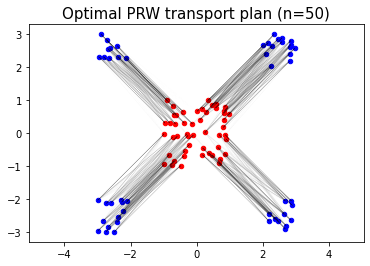

In [10]:
n = 50
X, Y, a, b = fragmented_hypercube(n, d, 0, dim=2)

_, pi, _ = rgas(
    X,
    Y,
    a,
    b,
    reg=0.2,
    max_iter=30,
    threshold=1e-03,
    max_iter_sinkhorn=30,
    threshold_sinkhorn=1e-03,
    gamma=0.01,
)

for i in range(X.shape[0]):
    for j in range(Y.shape[0]):
        if pi[i, j] > 0.0:
            plt.plot(
                [X[i, 0], Y[j, 0]], [X[i, 1], Y[j, 1]], c="k", lw=30 * pi[i, j]
            )

plt.scatter(X[:, 0], X[:, 1], s=20, c="r")
plt.scatter(Y[:, 0], Y[:, 1], s=20, c="b")
plt.title("Optimal PRW transport plan (n=%d)" % (X.shape[0],), fontsize=15)
plt.axis("equal")
plt.show()